# Model validation Wave Heights

Note: this notebook requires the model output data.

This notebook compares the point data extracted from the model results against the corresponding observations.

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Load packages

In [ ]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h
import pandas as pd

### Define metrics

In [2]:
ms.options.metrics.list = ["bias", "rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

### Define paths

In [3]:
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
fig_fldr = "../figures/" 
save_fig = False if "sample" in mr_fldr else True
show_fig = True

### Load points data

Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [4]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Sign*", time = slice("2022-01-03", None))

## Compare to wave height station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [5]:
swhlist = h.get_swh_point_obs(obs_fldr = "../observations/", station_file="stations_subset.csv")

### Spatial coverage

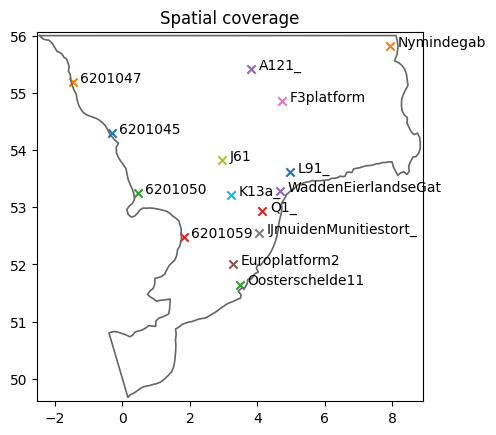

In [6]:
msh = mikeio.open("../input/Mesh_8000_elems.mesh")
ms.plotting.spatial_overview(swhlist, mod=msh);

Match the right model result timeseries and observation.

In [7]:
mr_fn = f"{mr_fldr}Area.dfsu"
mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[0], name="MIKE21")

cmps = []
for o in swhlist:
    print(f"Processing {o.name}...")
    mr = ms.PointModelResult(ds[o.name+": Sign. Wave Height"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print("Station ", o.name)
        print(e)
    cmps.append(cmp)
cc = ms.ComparerCollection(cmps)

Processing 6201045...
Processing 6201047...
Processing 6201050...
Processing 6201059...
Processing A121_...
Processing Europlatform2...
Processing F3platform...
Processing IJmuidenMunitiestort_...
Processing J61...
Processing K13a_...
Processing L91_...
Processing Nymindegab...
Processing Oosterschelde11...
Processing Q1_...
Processing WaddenEierlandseGat...


## Skill table (you could add the mean_skill after, it is always a good summary)

In [8]:
cc.skill().round(3)

,n,bias,rmse,mae,cc,si,r2
observation,,,,,,,
6201045,31633,0.092,0.247,0.186,0.952,0.222,0.891
6201047,34774,0.041,0.209,0.153,0.954,0.215,0.906
6201050,34295,0.097,0.194,0.147,0.922,0.226,0.770
6201059,34816,0.162,0.260,0.191,0.931,0.254,0.709
A121_,10337,0.371,0.509,0.402,0.968,0.154,0.839
Europlatform2,102129,0.158,0.317,0.214,0.965,0.221,0.834
F3platform,103932,0.155,0.344,0.240,0.970,0.174,0.906
IJmuidenMunitiestort_,100960,0.101,0.264,0.182,0.967,0.185,0.907
J61,104058,0.139,0.323,0.228,0.962,0.193,0.879


## Example timeseries

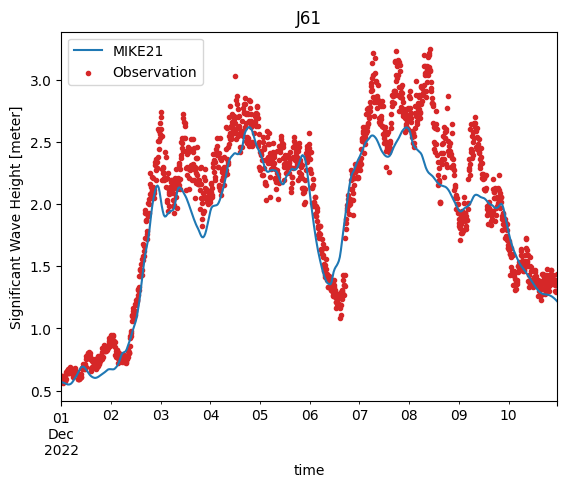

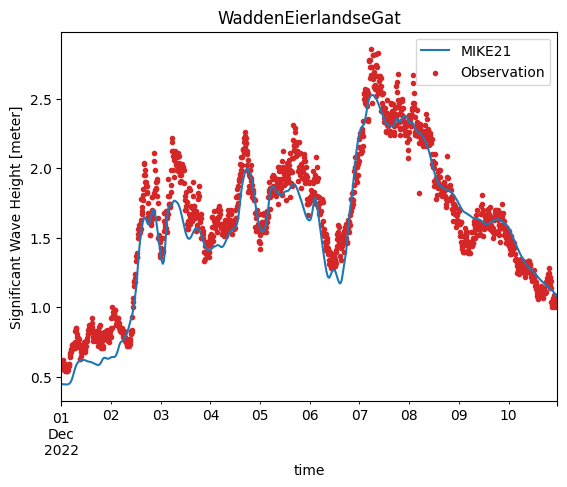

In [9]:
t_plot = slice("2022-12-01","2022-12-10") if "2022-12-01" in ds.time else slice(None, None)
cc["J61"].sel(time=t_plot).plot.timeseries();

cc["WaddenEierlandseGat"].sel(time=t_plot).plot.timeseries();

## Scatter plots

fig saved to: ../figures/modelskill_comparison_6201045.png


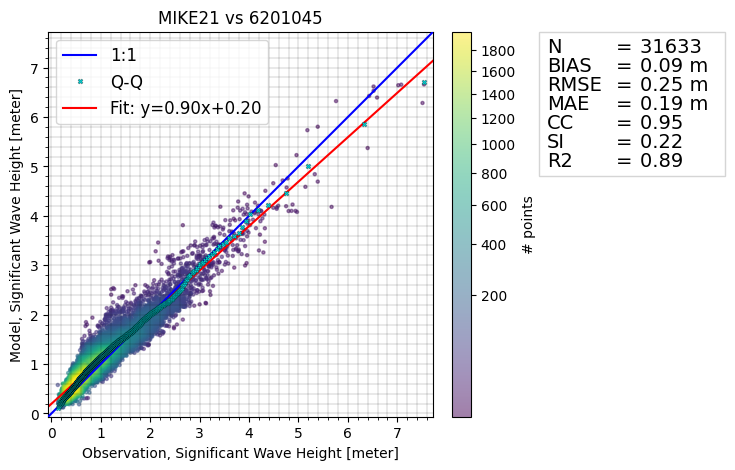

In [ ]:
n_points_shown = 10000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_fig:
        plt.savefig(f"{fig_fldr}modelskill_comparison_{cmp.name}.png", bbox_inches='tight');
        print(f"fig saved to: {fig_fldr}modelskill_comparison_{cmp.name}.png")
    if show_fig:
        plt.show()
    else:
        plt.close()